QC Classifier
---
Testing scRNA-seq QC machine learning classifier approaches against manually-filtered dataset.

In [1]:
import sys
sys.path.append('../')
from QC import *
sc.settings.set_figure_params(dpi=100, frameon=False)

In [ ]:
# reload fcc module while working
import sys
del sys.modules['ml_utils']
from ml_utils import *

In [2]:
# read in annotated dataset
%time s3 = sc.read_h5ad('../data/3072-AS-3-ACAGTG_S3.h5ad')

CPU times: user 4.21 s, sys: 669 ms, total: 4.88 s
Wall time: 4.94 s


In [3]:
# look at size and contents of dataset
s3

AnnData object with n_obs × n_vars = 10566 × 38459 
    obs: 'ken_filter'

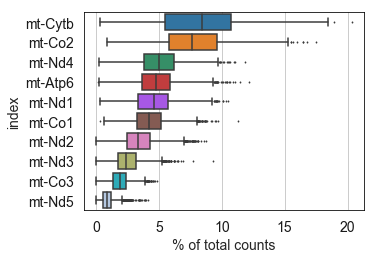

In [5]:
# checkpoint raw data for future filtering
s3.raw = s3
# look at highest expression by gene across all cells
sc.pl.highest_expr_genes(s3, n_top=10)

---
`fcc` recipe for preprocessing

In [6]:
sys.path.append('../../furry-couscous/')
from fcc_utils import recipe_fcc, gf_icf_markers

In [7]:
%time recipe_fcc(s3, mito_names='mt-')

CPU times: user 11.7 s, sys: 2.63 s, total: 14.3 s
Wall time: 14.3 s


In [8]:
# look at contents of dataset following pipeline
s3

AnnData object with n_obs × n_vars = 10566 × 38459 
    obs: 'ken_filter', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'ranked_total_counts', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'gf-icf'

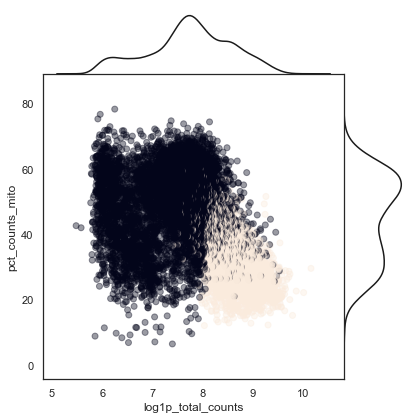

In [9]:
g = sns.JointGrid('log1p_total_counts', 'pct_counts_mito', data=s3.obs, space=0)
g = g.plot_joint(plt.scatter, c=s3.obs['ken_filter'], alpha=0.4)
g = g.plot_marginals(sns.distplot, kde=True, hist=False, color="k")

### Find inflection point

Inflection point at index
bcATSW     3685
bcGNHP     5484
bcHXYX     7544
bcGCEW     9753
bcFJFI    10565
Name: total_counts, dtype: int64 for [0, 30, 60, 90, 100] percentiles of greatest secant distances


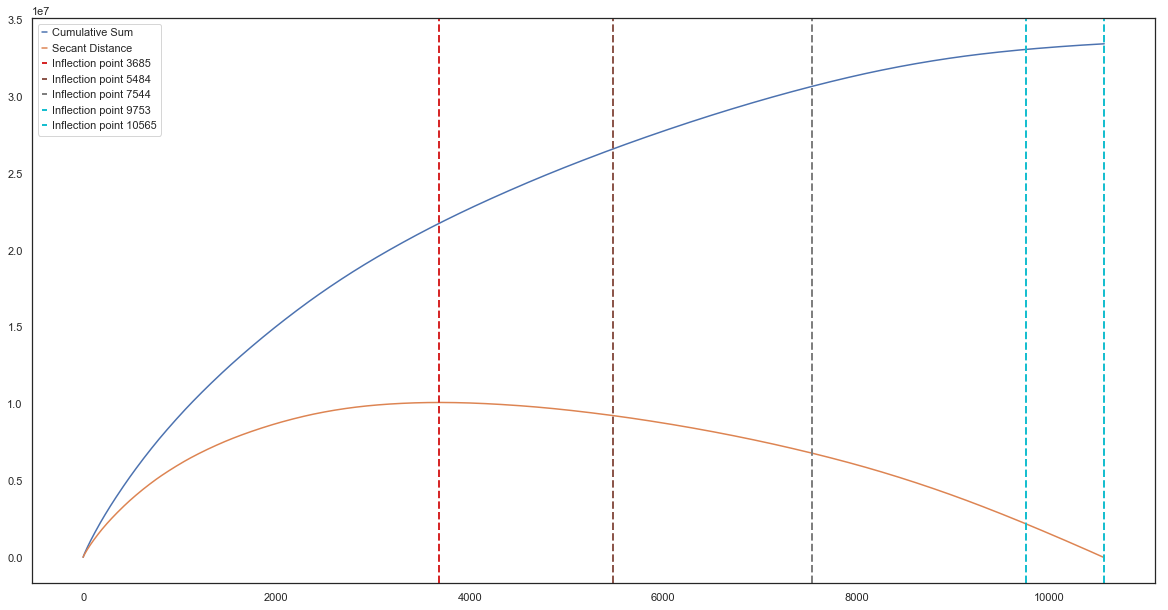

In [10]:
find_inflection(s3, inflection_percentiles = [0,30,60,90,100])

In [12]:
s3.obs['total_counts'][9753] # see the total counts for the cutoff point

560.0

In [20]:
# create new "observation" as empty droplet label
s3.obs['twostep_empty'] = np.where(s3.obs['total_counts']<=s3.obs['total_counts'][9753], 1, -1) # 1 is empty, -1 is unlabeled
s3.obs.loc[(s3.obs['ranked_total_counts']>=s3.n_obs*0.80)&(s3.obs['pct_counts_mito']<30), 'twostep_empty'] = 0 # take top 1% of dataset by total UMI counts and add as "not empty"

In [21]:
s3.obs['twostep_empty'].value_counts()

-1    8560
 0    1193
 1     813
Name: twostep_empty, dtype: int64

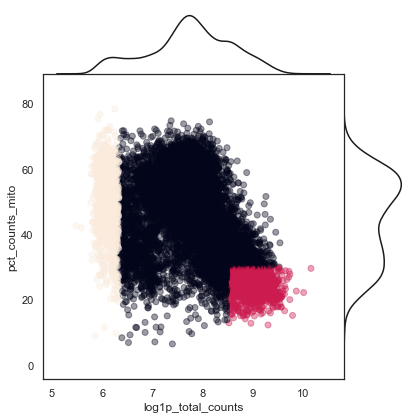

In [22]:
g = sns.JointGrid('log1p_total_counts', 'pct_counts_mito', data=s3.obs, space=0)
g = g.plot_joint(plt.scatter, c=s3.obs['twostep_empty'], alpha=0.4)
g = g.plot_marginals(sns.distplot, kde=True, hist=False, color="k")

### Normalize and perform linear dimensionality reduction with PCA

In [23]:
%%time
sc.pp.normalize_total(s3, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s3) # log1p transformation
sc.pp.scale(s3, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 2.47 s, sys: 308 ms, total: 2.78 s
Wall time: 2.78 s


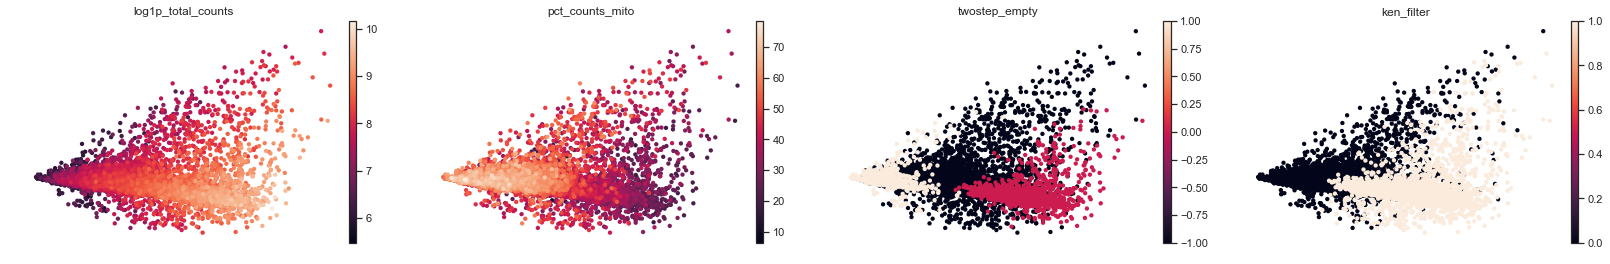

CPU times: user 8.99 s, sys: 1.46 s, total: 10.5 s
Wall time: 2.03 s


In [24]:
%%time
sc.tl.pca(s3, n_comps=100) # perform PCA and plot results
sc.pl.pca(s3, color=['log1p_total_counts','pct_counts_mito','twostep_empty','ken_filter'], ncols=4, size=75)

---
### TwoStep

In [25]:
# define X and y for classifier training for simplicity
X = s3.obsm['X_pca'] # training data is PCA results
y = s3.obs['twostep_empty'].copy(deep=True) # training labels are from .obs df

In [26]:
%%time
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1) # define random forest classifier, you can plug in any classifier though!
s3.obs['twostep_score'], s3.obs['twostep_label'] = twoStep(clf=rf, X=X, y=y, n_iter=18)

Step 1 labeled 566 new positives and 599 new negatives.
Iteration 1: Doing step 2... Step 1 labeled 212 new positives and 150 new negatives.
Iteration 2: Doing step 2... Step 1 labeled 168 new positives and 40 new negatives.
Iteration 3: Doing step 2... Step 1 labeled 198 new positives and 23 new negatives.
Iteration 4: Doing step 2... Step 1 labeled 124 new positives and 14 new negatives.
Iteration 5: Doing step 2... Step 1 labeled 131 new positives and 14 new negatives.
Iteration 6: Doing step 2... Step 1 labeled 81 new positives and 12 new negatives.
Iteration 7: Doing step 2... Step 1 labeled 68 new positives and 12 new negatives.
Iteration 8: Doing step 2... Step 1 labeled 40 new positives and 3 new negatives.
Iteration 9: Doing step 2... Step 1 labeled 27 new positives and 3 new negatives.
Iteration 10: Doing step 2... Step 1 labeled 32 new positives and 5 new negatives.
Iteration 11: Doing step 2... Step 1 labeled 31 new positives and 6 new negatives.
Iteration 12: Doing step 2.

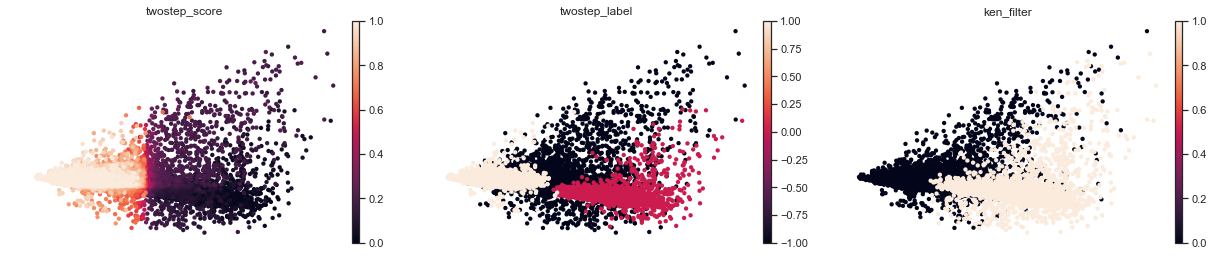

In [27]:
sc.pl.pca(s3, color=['twostep_score','twostep_label','ken_filter'], size=75)

In [43]:
# threshold twostep score at 0.5 for dead cells / empty droplets
s3.obs['twostep_result'] = np.where(s3.obs['twostep_score']<0.1, 1, 0)

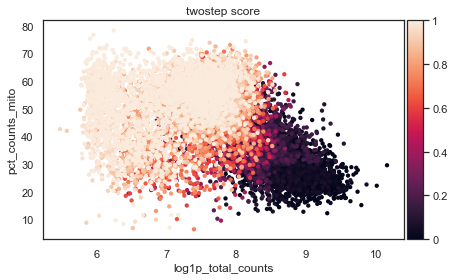

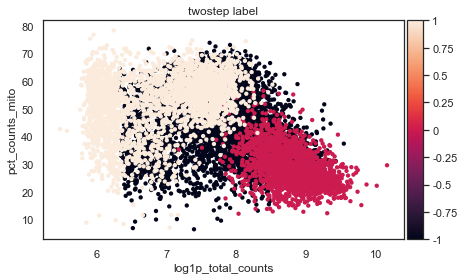

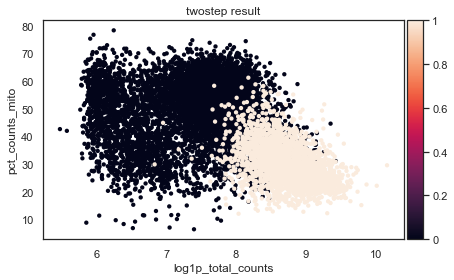

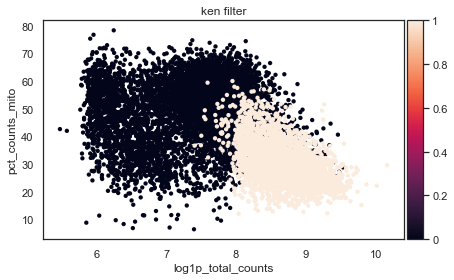

In [44]:
# look at the training labels we've picked
sc.pl.scatter(s3, x='log1p_total_counts', y='pct_counts_mito', color='twostep_score', size=75)
sc.pl.scatter(s3, x='log1p_total_counts', y='pct_counts_mito', color='twostep_label', size=75)
sc.pl.scatter(s3, x='log1p_total_counts', y='pct_counts_mito', color='twostep_result', size=75)
sc.pl.scatter(s3, x='log1p_total_counts', y='pct_counts_mito', color='ken_filter', size=75)

In [45]:
s3.obs['ken_filter'].value_counts()

0    7576
1    2990
Name: ken_filter, dtype: int64

In [46]:
s3.obs['twostep_result'].value_counts()

0    8011
1    2555
Name: twostep_result, dtype: int64

In [104]:
s3_filter = s3[s3.obs['twostep_result']==1,:].copy() # move forward with non-empty droplets
s3_filter.X = s3_filter.raw.X

### Normalize and perform linear dimensionality reduction with PCA

In [48]:
%%time
sc.pp.normalize_total(s3_filter, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s3_filter) # log1p transformation
sc.pp.scale(s3_filter, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 622 ms, sys: 30.9 ms, total: 653 ms
Wall time: 653 ms


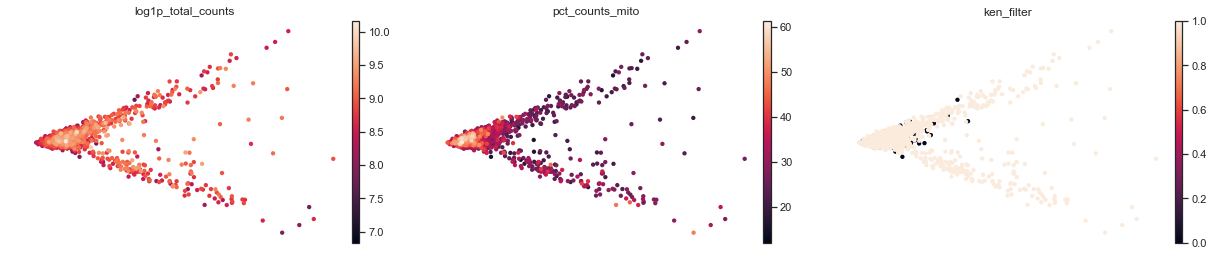

CPU times: user 3.38 s, sys: 534 ms, total: 3.91 s
Wall time: 683 ms


In [49]:
%%time
sc.tl.pca(s3_filter, n_comps=100) # perform PCA and plot results
sc.pl.pca(s3_filter, color=['log1p_total_counts','pct_counts_mito','ken_filter'], size=75)

### Clustering

In [50]:
%%time
sc.pp.neighbors(s3_filter, n_neighbors=30, n_pcs=20, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.louvain(s3_filter, resolution=1.5, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compile

CPU times: user 3.55 s, sys: 118 ms, total: 3.67 s
Wall time: 3.07 s


/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


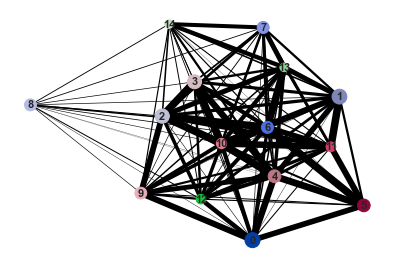

In [51]:
sc.tl.paga(s3_filter) #perform PAGA
sc.pl.paga(s3_filter)

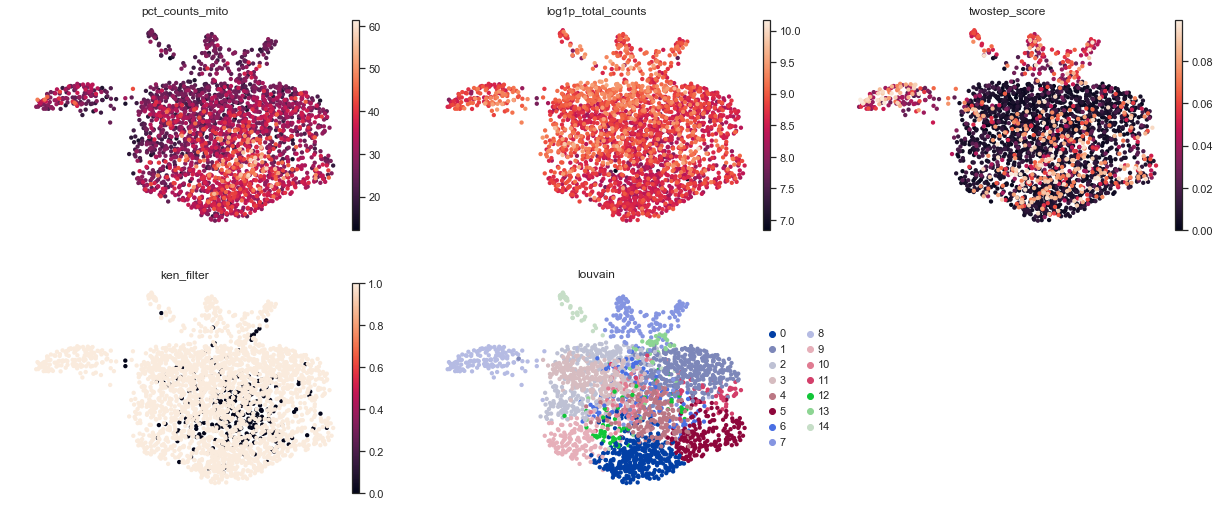

In [52]:
sc.tl.umap(s3_filter, init_pos=sc.tl._utils.get_init_pos_from_paga(s3_filter))
sc.pl.umap(s3_filter, color=['pct_counts_mito','log1p_total_counts','twostep_score','ken_filter','louvain'], size=75, ncols=3)

In [53]:
%%time
sc.tl.rank_genes_groups(s3_filter, 'louvain', method='wilcoxon')

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:388: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


CPU times: user 6.66 s, sys: 1.44 s, total: 8.1 s
Wall time: 8.1 s


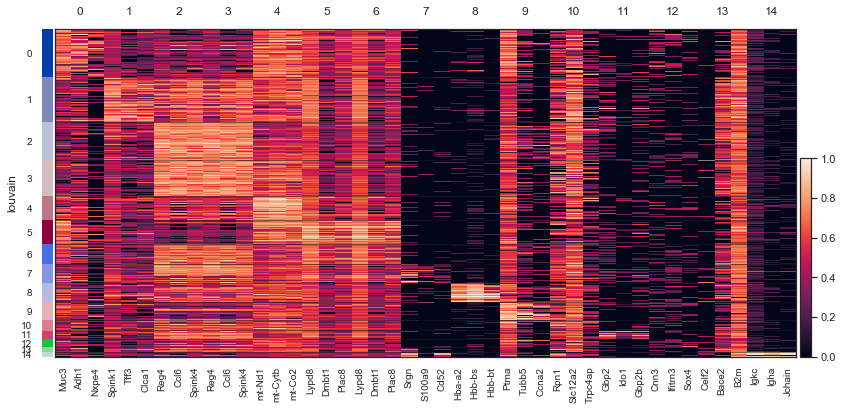

In [54]:
sc.pl.rank_genes_groups_heatmap(s3_filter, n_genes=3, standard_scale='var', use_raw=False, dendrogram=False)

---
## Ken Filtering

In [103]:
s3_gold = s3[s3.obs['ken_filter']==1,:].copy() # move forward with non-empty droplets
s3_gold.X = s3_gold.raw.X

### Normalize and perform linear dimensionality reduction with PCA

In [56]:
%%time
sc.pp.normalize_total(s3_gold, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s3_gold) # log1p transformation
sc.pp.scale(s3_gold, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 741 ms, sys: 38.6 ms, total: 779 ms
Wall time: 779 ms


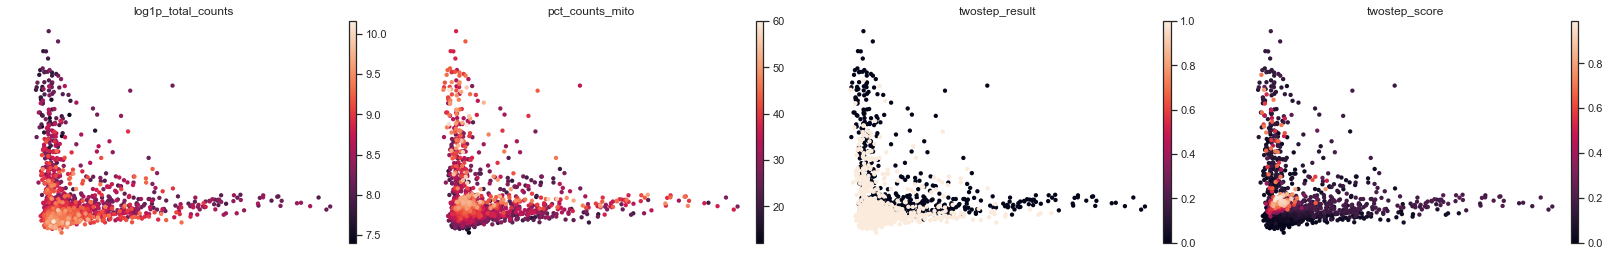

CPU times: user 3.51 s, sys: 977 ms, total: 4.49 s
Wall time: 877 ms


In [57]:
%%time
sc.tl.pca(s3_gold, n_comps=100) # perform PCA and plot results
sc.pl.pca(s3_gold, color=['log1p_total_counts','pct_counts_mito','twostep_result','twostep_score'], size=75)

### Clustering

In [58]:
%%time
sc.pp.neighbors(s3_gold, n_neighbors=30, n_pcs=20, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.louvain(s3_gold, resolution=1.5, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

CPU times: user 1.21 s, sys: 122 ms, total: 1.33 s
Wall time: 647 ms


/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


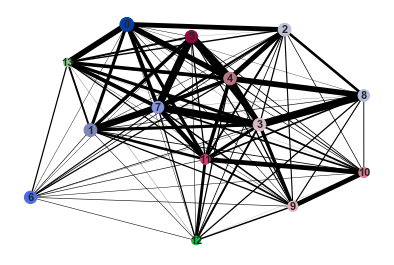

In [59]:
sc.tl.paga(s3_gold) #perform PAGA
sc.pl.paga(s3_gold)

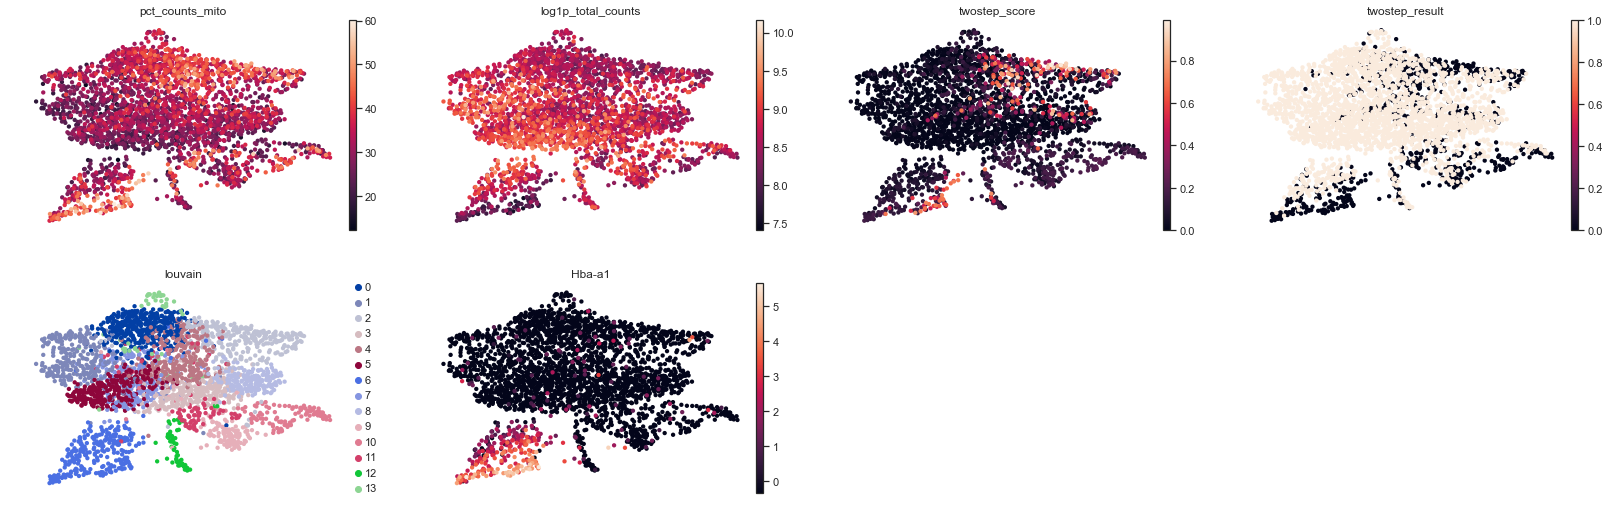

In [61]:
sc.tl.umap(s3_gold, init_pos=sc.tl._utils.get_init_pos_from_paga(s3_gold))
sc.pl.umap(s3_gold, color=['pct_counts_mito','log1p_total_counts','twostep_score','twostep_result','louvain','Hba-a1'], size=75)

In [62]:
%%time
sc.tl.rank_genes_groups(s3_gold, 'louvain', method='wilcoxon')

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:388: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


CPU times: user 7.44 s, sys: 1.61 s, total: 9.04 s
Wall time: 9.04 s


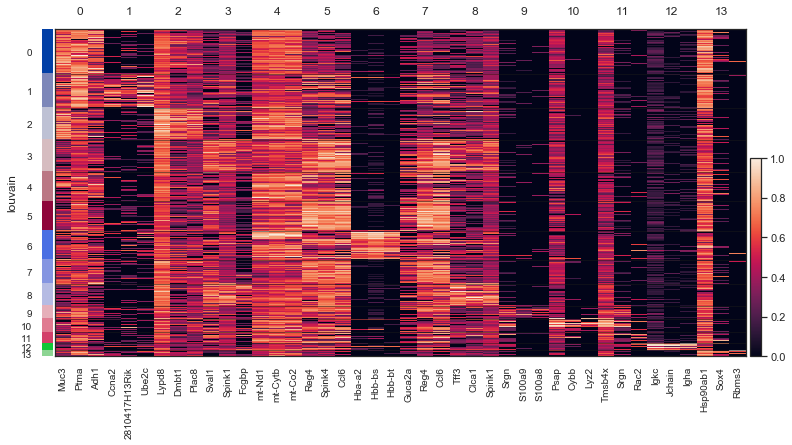

In [63]:
sc.pl.rank_genes_groups_heatmap(s3_gold, n_genes=3, standard_scale='var', use_raw=False, dendrogram=False)

---
### PU Bagging

In [64]:
# define X and y for classifier training for simplicity
X = s3.obsm['X_pca'] # training data is PCA results
y = s3.obs['twostep_empty'].copy(deep=True) # training labels are from .obs df

In [65]:
%%time

bc = BaggingClassifierPU(
    RandomForestClassifier(), 
    n_estimators = 1000,  # 1000 trees as usual
    max_samples = y.value_counts()[1], # Balance the positives and unlabeled in each bag
    n_jobs = -1           # Use all cores
)
bc.fit(X, y)

results_bagging_empty = bc.oob_decision_function_[:,1]

CPU times: user 13.4 s, sys: 1.48 s, total: 14.9 s
Wall time: 32.5 s


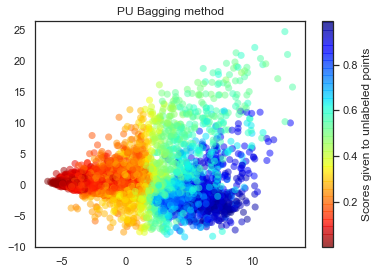

In [66]:
# visualize PU bagging results
plt.scatter(
    X[:,0], X[:,1], 
    c = results_bagging_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU Bagging method')
plt.show()

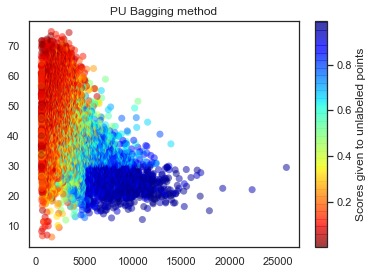

In [67]:
# visualize final TwoStep results
plt.scatter(
    s3.obs['total_counts'], s3.obs['pct_counts_mito'], 
    c = results_bagging_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU Bagging method')
plt.show()

In [77]:
s3.obs['bagging_result'] = np.where(results_bagging_empty>0.5, 1, 0)

In [78]:
s3.obs['ken_filter'].value_counts()

0    7576
1    2990
Name: ken_filter, dtype: int64

In [79]:
s3.obs['bagging_result'].value_counts()

0    7779
1    2787
Name: bagging_result, dtype: int64

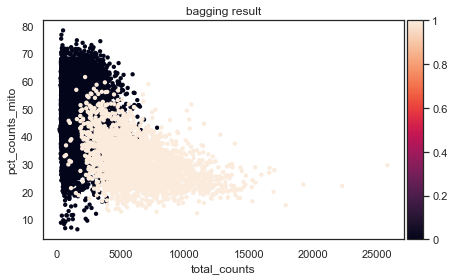

In [80]:
# look at our previously-defined labels
sc.pl.scatter(s3, x='total_counts', y='pct_counts_mito', color='bagging_result', size=75)

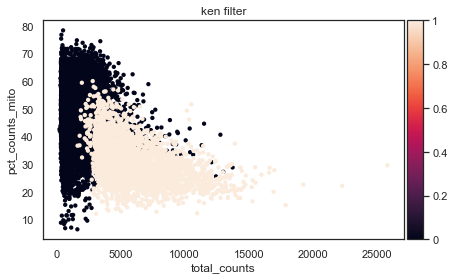

In [81]:
# look at low-quality and dead cell distribution with Ken's filtering
sc.pl.scatter(s3, x='total_counts', y='pct_counts_mito', color='ken_filter', size=75)

In [99]:
s3_notempty = s3[s3.obs['bagging_result']==1,:].copy() # move forward with non-empty droplets

In [100]:
s3_notempty.X = s3_notempty.raw.X

### Normalize and perform linear dimensionality reduction with PCA

In [84]:
%%time
sc.pp.normalize_total(s3_notempty, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s3_notempty) # log1p transformation
sc.pp.scale(s3_notempty, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 704 ms, sys: 26.2 ms, total: 730 ms
Wall time: 730 ms


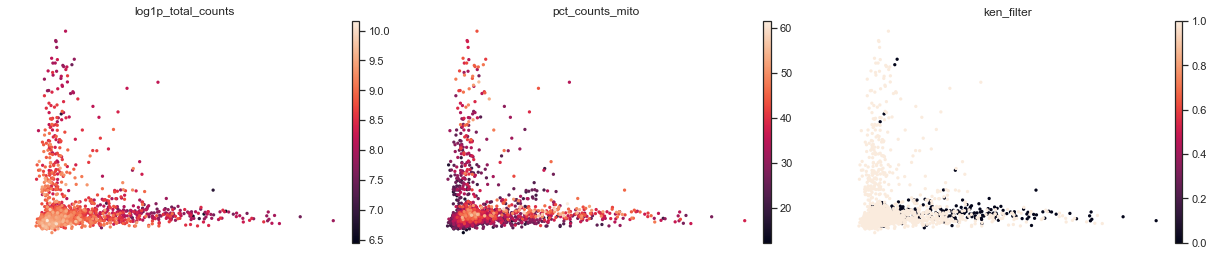

CPU times: user 3.15 s, sys: 843 ms, total: 3.99 s
Wall time: 727 ms


In [85]:
%%time
sc.tl.pca(s3_notempty, n_comps=100) # perform PCA and plot results
sc.pl.pca(s3_notempty, color=['log1p_total_counts','pct_counts_mito','ken_filter'], ncols=3)

### Clustering

In [86]:
%%time
sc.pp.neighbors(s3_notempty, n_neighbors=30, n_pcs=20, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.louvain(s3_notempty, resolution=1.5, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

CPU times: user 1.17 s, sys: 117 ms, total: 1.29 s
Wall time: 653 ms


/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


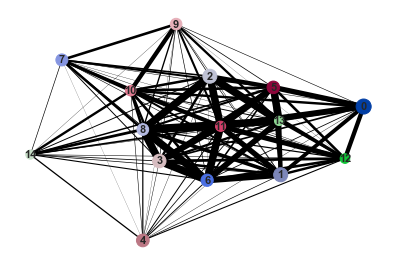

In [87]:
sc.tl.paga(s3_notempty) #perform PAGA
sc.pl.paga(s3_notempty)

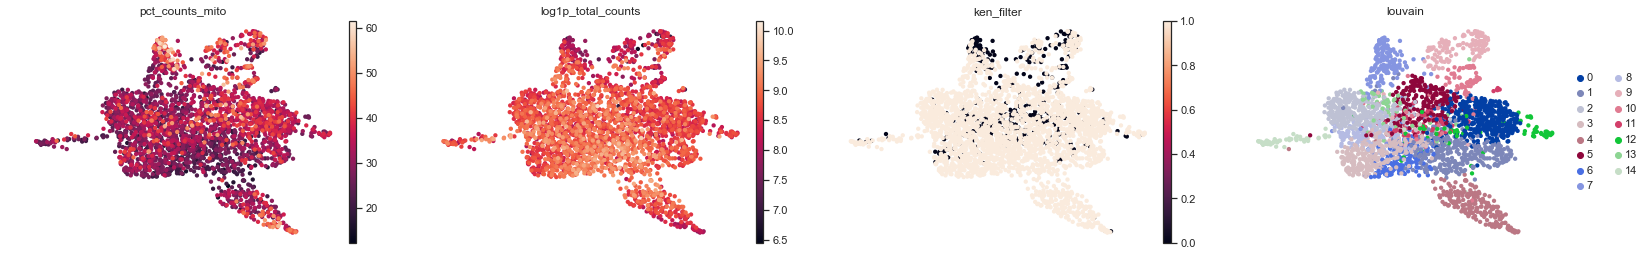

In [89]:
sc.tl.umap(s3_notempty, init_pos=sc.tl._utils.get_init_pos_from_paga(s3_notempty))
sc.pl.umap(s3_notempty, color=['pct_counts_mito','log1p_total_counts','ken_filter','louvain'], size=75)

In [90]:
%%time
sc.tl.rank_genes_groups(s3_notempty, 'louvain', method='wilcoxon')

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:388: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


CPU times: user 7.59 s, sys: 1.12 s, total: 8.71 s
Wall time: 8.71 s


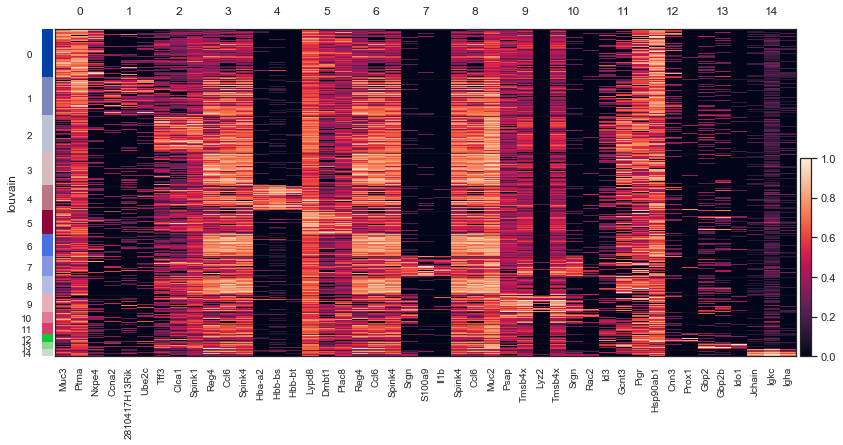

In [91]:
sc.pl.rank_genes_groups_heatmap(s3_notempty, n_genes=3, standard_scale='var', use_raw=False, dendrogram=False)